<a href="https://colab.research.google.com/github/hbi133580/bird-classification/blob/main/Current_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upload images to Colab disk to speed up training
# Much faster than reading from google drive
! 7z x /content/drive/MyDrive/256x256.zip -o/content/256x256

In [ ]:
import pandas as pd 

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Prepare data

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
# Location for training, testing data
labels = pd.read_csv('/content/drive/MyDrive/birds21wi/labels.csv')
submission = pd.read_csv('/content/drive/MyDrive/birds21wi/sample.csv')

train_path = '/content/256x256'
test_path = '/content/256x256test'

# Hyper parameters
num_epochs = 9
batch_size = 32
learning_rate = 0.01
decay = 0
dropout = 0
momentum = 0.7

img_size = 256
num_classes = 555

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        
        img_path = os.path.join(self.path, img_name)
        
        image = Image.open(img_path)
        if (image.mode != 'RGB'):
            image = image.convert("RGB")

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Get data

# Normalization values expected by ResNet
train_transform = transforms.Compose([transforms.RandomCrop(img_size, padding=8, padding_mode='edge'), # Take crops from padded images
                                      transforms.RandomHorizontalFlip(), # 50% of time flip image along y-axis
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([#transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train, valid = train_test_split(labels, test_size=0.2)

train_data = BirdDataset(train, train_path, train_transform)
valid_data = BirdDataset(valid, train_path, valid_transform)
test_data = BirdDataset(submission, test_path, test_transform)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False)


# Net

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, inputs=img_size*img_size*3, hidden=512, outputs=num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden) # fully connected:
        # every neuron in this layer is fully connected to attaching neurons
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)  # activaction function, allows for non-linearity
        x = self.fc2(x)
        return x

In [ ]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
def get_pretrained_ResNet():
    pretrained_model = models.resnet34(pretrained=True)
    num_features = pretrained_model.fc.in_features # num input features for the last layer

    pretrained_model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_features, num_classes)
    )
    return pretrained_model

# Train

In [ ]:
model = get_pretrained_ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=momentum, weight_decay=decay, nesterov=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6], gamma=0.1)

verbose = False # whether to print out loss between epochs

# keeping-track-of-losses 
train_losses = []
valid_losses = []

i = 0
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    my_loss = 0.0

    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)

        my_loss += loss.item()
        
        if i % 300 == 299:    # print every 300 mini-batches
            if verbose:
                print('[%d, %5d] loss: %.3f' %(epoch, i + 1, my_loss / 300))
            my_loss = 0.0
        i = i + 1
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # update learning rate
    scheduler.step()

    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

# Testing
Getting training and testing accuracy

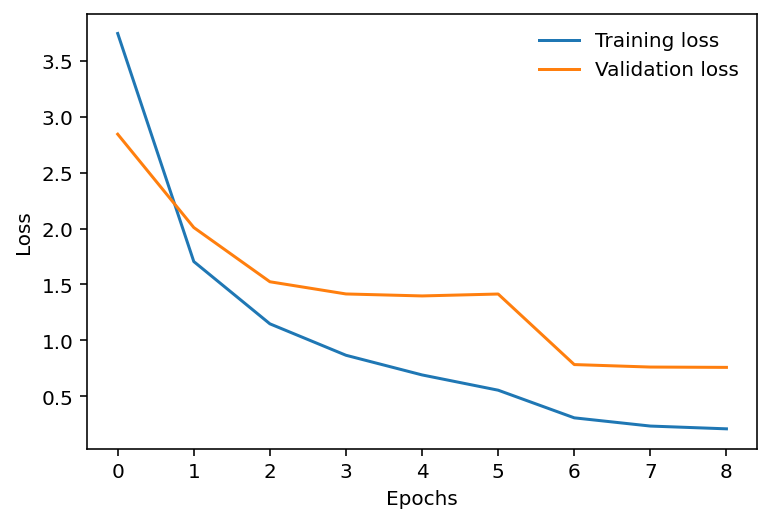

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
# Check testing accuracy
model.eval()  # it-disables-dropout, batch norm etc
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 78.85388305458316 %


In [ ]:
# Check training accuracy
model.eval()  # it-disables-dropout, batch norm etc
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Train Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Train Accuracy of the model: 97.54611170540375 %


# Get Test Predictions
(for Kaggle)

In [ ]:
# Open a previously trained model
model = pretrained_model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/model_9_epoch.ckpt'))

<All keys matched successfully>

In [ ]:
# Get previous predictions
model.eval()  # it-disables-dropout, batch norm etc
test_predictions = []
i = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions += predicted.tolist()
        if (i % 100 == 0):
            print(i)
        i = i + 1



In [ ]:
# Write predictions to csv file for submission
import csv

with open('/content/predictions.csv', 'w') as f:
    writer = csv.writer(f)
    for val in test_predictions:
        writer.writerow([val])